In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from keras import backend as K
import cv2
import glob
import pandas as pd
from matplotlib import pyplot as plt
from math import ceil, floor
from tqdm import tqdm, tqdm_notebook
from skimage import morphology
from keras.utils.data_utils import get_file
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, ZeroPadding2D, Dense, Dropout, \
    Flatten, Input, LSTM, TimeDistributed
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import recall_score, roc_auc_score, f1_score, roc_curve, classification_report

Using TensorFlow backend.


In [2]:
base_data_dir = '../data/chest_xray/'

data_dir = base_data_dir + 'prepared/'
normal_dir = data_dir + 'normal/'
pneumonia_dir = data_dir + 'pneumonia/'
bacteria_dir = pneumonia_dir + 'bacteria/'
virus_dir = pneumonia_dir + 'virus/'
models_dir = './models/'

for directory in [normal_dir, bacteria_dir, virus_dir, models_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [3]:
bddl = len(base_data_dir)

file_names_normal = [path[bddl:] for path in glob.glob(base_data_dir + 'train/NORMAL/*.jpeg')] + [path[bddl:] for path
                                                                                                  in glob.glob(
        '../data/chest_xray/test/NORMAL/*.jpeg')] + [path[bddl:] for path in
                                                     glob.glob('../data/chest_xray/val/NORMAL/*.jpeg')]
file_names_pneumonia = [path[bddl:] for path in glob.glob(base_data_dir + 'train/PNEUMONIA/*.jpeg')] + [path[bddl:] for
                                                                                                        path in
                                                                                                        glob.glob(
                                                                                                            '../data/chest_xray/test/PNEUMONIA/*.jpeg')] + [
                           path[bddl:] for path in glob.glob('../data/chest_xray/val/PNEUMONIA/*.jpeg')]

In [4]:
normal_patterns = [
    base_data_dir + 'train/NORMAL/*.jpeg',
    base_data_dir + 'test/NORMAL/*.jpeg',
    base_data_dir + 'val/NORMAL/*.jpeg'
]

bacteria_patterns = [
    base_data_dir + 'train/PNEUMONIA/*bacteria*.jpeg',
    base_data_dir + 'test/PNEUMONIA/*bacteria*.jpeg',
    base_data_dir + 'val/PNEUMONIA/*bacteria*.jpeg'
]

virus_patterns = [
    base_data_dir + 'train/PNEUMONIA/*virus*.jpeg',
    base_data_dir + 'test/PNEUMONIA/*virus*.jpeg',
    base_data_dir + 'val/PNEUMONIA/*virus*.jpeg'
]

raw_normal = [item for sublist in [glob.glob(path) for path in normal_patterns] for item in sublist]
raw_bacteria = [item for sublist in [glob.glob(path) for path in bacteria_patterns] for item in sublist]
raw_virus = [item for sublist in [glob.glob(path) for path in virus_patterns] for item in sublist]

In [5]:
get_file('lung_segmentation.hdf5',
         'https://raw.githubusercontent.com/imlab-uiip/lung-segmentation-2d/master/trained_model.hdf5',
         cache_dir = models_dir, cache_subdir = 'lung')

'./models/lung/lung_segmentation.hdf5'

In [6]:
model_name = models_dir + 'lung/lung_segmentation.hdf5'
UNet = load_model(model_name)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [7]:
def adjust_gamma(image, gamma = 1.0):
    invGamma = 1.0 / gamma
    table = np.array([
        ((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))


def adjust_contrast(image, contrast = 0):
    buf = image.copy()
    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)
    return buf


def normalize_image(original, target_width = 256):
    im_shape = (256, 256)
    original_width = original.shape[1]
    original_height = original.shape[0]

    width_coeff = 256 / original_width
    height_coeff = 256 / original_height

    img = cv2.resize(original, im_shape, interpolation = cv2.INTER_AREA)
    img = cv2.equalizeHist(img)
    img = adjust_gamma(img, 0.75)
    img = img * 1.2
    img = np.clip(img, 0, 255)

    img2 = img.astype(float)
    img2 -= img2.mean()
    img2 /= img2.std()

    img2 = np.expand_dims(img2, -1)
    inp_shape = img2.shape
    pred = UNet.predict([[img2]])[..., 0].reshape(inp_shape[:2])
    pr = pred > 0.5
    pr = remove_small_regions(pr, 0.01 * np.prod(im_shape))
    pr = pr.astype(int)

    non_empty_columns = np.where(pr.max(axis = 0) > 0)[0]
    non_empty_rows = np.where(pr.max(axis = 1) > 0)[0]
    left = min(non_empty_columns) if len(non_empty_columns) > 0 else 0
    right = max(non_empty_columns) if len(non_empty_columns) > 0 else 256
    top = min(non_empty_rows) if len(non_empty_rows) > 0 else 0
    bottom = max(non_empty_rows) if len(non_empty_rows) > 0 else 256

    if right < 256 / 1.9:
        right = 256 - left

    if left > 256 / 2.1:
        left = 256 - right

    l = floor(left / width_coeff)
    t = floor(top / height_coeff)
    w = floor((right - left) / width_coeff)
    h = floor((bottom - top) / height_coeff)

    cropped = original[t:t + h, l:l + w]
    resized = cv2.resize(cropped, (target_width, target_width), interpolation = cv2.INTER_AREA)
    equalized = cv2.equalizeHist(resized)
    return equalized


def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [8]:
image_width = 256

i = 0
for path in tqdm_notebook(file_names_normal):
    output_path = normal_dir + '{0:04d}.jpeg'.format(i)
    if not os.path.exists(output_path):
        img = cv2.imread(base_data_dir + path, 0)
        normalized = normalize_image(img, image_width)
        cv2.imwrite(output_path, normalized)
    i += 1

i = 0
for path in tqdm_notebook(file_names_pneumonia):
    if 'bacteria' in path:
        output_path = bacteria_dir + '{0:04d}.jpeg'.format(i)
    else:
        output_path = virus_dir + '{0:04d}.jpeg'.format(i)
    if not os.path.exists(output_path):
        img = cv2.imread(base_data_dir + path, 0)
        normalized = normalize_image(img, image_width)
        cv2.imwrite(output_path, normalized)
    i += 1

In [9]:
normal_df = pd.DataFrame(
    {'path': glob.glob(normal_dir + '*.jpeg'), 'normal': 1, 'bacteria': 0, 'virus': 0, 'target': 'Normal'})
bacteria_df = pd.DataFrame(
    {'path': glob.glob(bacteria_dir + '*.jpeg'), 'normal': 0, 'bacteria': 1, 'virus': 0, 'target': 'Pneumonia'})
virus_df = pd.DataFrame(
    {'path': glob.glob(virus_dir + '*.jpeg'), 'normal': 0, 'bacteria': 0, 'virus': 1, 'target': 'Pneumonia'})

# normal_df = pd.DataFrame(
#     {'path': raw_normal, 'normal': 1, 'bacteria': 0, 'virus': 0, 'target': 'Normal'})
# bacteria_df = pd.DataFrame(
#     {'path': raw_bacteria, 'normal': 0, 'bacteria': 1, 'virus': 0, 'target': 'Pneumonia'})
# virus_df = pd.DataFrame(
#     {'path': raw_virus, 'normal': 0, 'bacteria': 0, 'virus': 1, 'target': 'Pneumonia'})

dataset = pd.concat([normal_df, bacteria_df, virus_df])
dataset = dataset.sort_values('path')
dataset = dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)

In [10]:
pd.set_option('max_colwidth', 100)
dataset.head(10)

,path,normal,bacteria,virus,target
0,../data/chest_xray/prepared/pneumonia/bacteria/3734.jpeg,0,1,0,Pneumonia
1,../data/chest_xray/prepared/pneumonia/bacteria/0326.jpeg,0,1,0,Pneumonia
2,../data/chest_xray/prepared/normal/0608.jpeg,1,0,0,Normal
3,../data/chest_xray/prepared/pneumonia/virus/3985.jpeg,0,0,1,Pneumonia
4,../data/chest_xray/prepared/pneumonia/virus/3986.jpeg,0,0,1,Pneumonia
5,../data/chest_xray/prepared/pneumonia/bacteria/3013.jpeg,0,1,0,Pneumonia
6,../data/chest_xray/prepared/normal/1045.jpeg,1,0,0,Normal
7,../data/chest_xray/prepared/pneumonia/virus/3039.jpeg,0,0,1,Pneumonia
8,../data/chest_xray/prepared/normal/0642.jpeg,1,0,0,Normal
9,../data/chest_xray/prepared/pneumonia/bacteria/1548.jpeg,0,1,0,Pneumonia


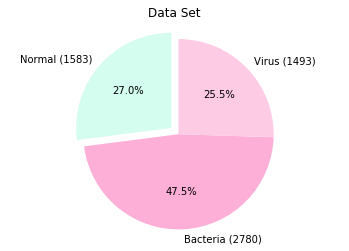

In [11]:
colors = ['#D4FCEF', '#FDAFD7', '#FECBE5']


def labels(normal_amount, bacteria_amount, virus_amount): return \
    'Normal ({0:d})'.format(normal_amount), \
    'Bacteria ({0:d})'.format(bacteria_amount), \
    'Virus ({0:d})'.format(virus_amount)


def sizes(normal_amount, bacteria_amount, virus_amount):
    total = normal_amount + bacteria_amount + virus_amount
    return [normal_amount / total, bacteria_amount / total, virus_amount / total]


fig1, ax1 = plt.subplots()
ax1.pie(sizes(normal_df.shape[0], bacteria_df.shape[0], virus_df.shape[0]),
        explode = (0.1, 0, 0), labels = labels(normal_df.shape[0], bacteria_df.shape[0], virus_df.shape[0]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax1.axis('equal')
ax1.title.set_text('Data Set')
plt.show()

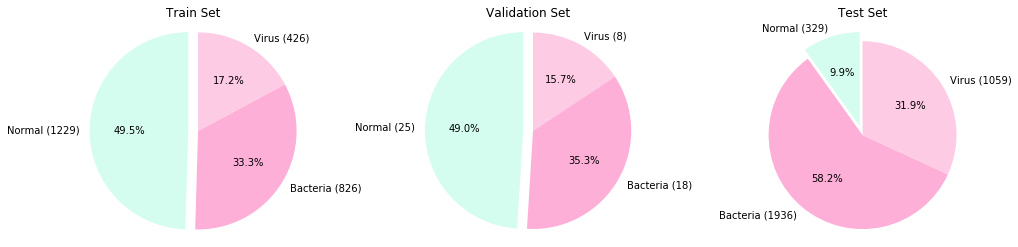

In [12]:
test_size = 0.2
validation_size = 0.02

sampler = RandomUnderSampler(random_state = 0)
X_balanced, _ = sampler.fit_resample(dataset[['path']].values, dataset[['target']].values)

balanced_dataset = pd.DataFrame({'path': X_balanced[:, 0]})
balanced_dataset = balanced_dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
balanced_dataset = pd.merge(balanced_dataset, dataset, on = 'path')
rest_dataset = pd.DataFrame(
    {'path': list(set(X_balanced[:, 0].tolist()).symmetric_difference(dataset[['path']].values[:, 0].tolist()))})
rest_dataset = rest_dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
rest_dataset = pd.merge(rest_dataset, dataset, on = 'path')

X_train_validation, X_test, y_train_validation, _ = train_test_split(
    balanced_dataset.path.values, balanced_dataset.target.values,
    test_size = test_size, random_state = 0)
X_train, X_validation, _, _ = train_test_split(
    X_train_validation, y_train_validation,
    test_size = validation_size, random_state = 3)

train_dataset = pd.merge(pd.DataFrame({'path': X_train}), dataset, on = 'path')
validation_dataset = pd.merge(pd.DataFrame({'path': X_validation}), dataset, on = 'path')
test_dataset = pd.concat([pd.merge(pd.DataFrame({'path': X_test}), dataset, on = 'path'), rest_dataset])

fig = plt.figure(figsize = (17, 4))
ax1 = fig.add_subplot(131)
ax1.pie(sizes(train_dataset.sum()[1], train_dataset.sum()[2], train_dataset.sum()[3]),
        explode = (0.1, 0, 0), labels = labels(train_dataset.sum()[1], train_dataset.sum()[2], train_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax1.axis('equal')
ax1.title.set_text('Train Set')

ax3 = fig.add_subplot(132)
ax3.pie(sizes(validation_dataset.sum()[1], validation_dataset.sum()[2], validation_dataset.sum()[3]),
        explode = (0.1, 0, 0),
        labels = labels(validation_dataset.sum()[1], validation_dataset.sum()[2], validation_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax3.axis('equal')
ax3.title.set_text('Validation Set')

ax2 = fig.add_subplot(133)
ax2.pie(sizes(test_dataset.sum()[1], test_dataset.sum()[2], test_dataset.sum()[3]),
        explode = (0.1, 0, 0), labels = labels(test_dataset.sum()[1], test_dataset.sum()[2], test_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax2.axis('equal')
ax2.title.set_text('Test Set')

plt.show()

In [13]:
imageGenerator = ImageDataGenerator(rescale = 1. / 255, horizontal_flip = True)
testGenerator = ImageDataGenerator(rescale = 1. / 255)

batch_size = 4
x_col = 'path'
y_col = 'target'
classes = ['Normal', 'Pneumonia']
mode = 'grayscale'
target_size = (150, 150)

print('Train generator:')
train_generator = imageGenerator.flow_from_dataframe(train_dataset, x_col = x_col, y_col = y_col,
                                                     seed = 0, target_size = target_size, batch_size = batch_size,
                                                     class_mode = 'binary', color_mode = mode)

print('\nValidation generator:')
validation_generator = testGenerator.flow_from_dataframe(validation_dataset, x_col = x_col, y_col = y_col,
                                                         seed = 0, target_size = target_size, batch_size = batch_size,
                                                         class_mode = 'binary', color_mode = mode, shuffle = False)

print('\nTest generator:')
test_generator = testGenerator.flow_from_dataframe(test_dataset, x_col = x_col, y_col = y_col,
                                                   seed = 0, target_size = target_size, batch_size = 1,
                                                   class_mode = 'binary', color_mode = mode, shuffle = False)

Train generator:
Found 2481 validated image filenames belonging to 2 classes.

Validation generator:
Found 51 validated image filenames belonging to 2 classes.

Test generator:
Found 3324 validated image filenames belonging to 2 classes.


In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = train_generator.image_shape))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.15))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.15))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.15))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.15))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 74, 74, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
___________________________

In [15]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta = 1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta = 1)

In [16]:
# optimizer = Adam(lr = 0.0001)

model.compile(loss = 'binary_crossentropy', optimizer = 'adam',
              metrics = ['accuracy', fmeasure, recall, precision])

train_generator.reset()
validation_generator.reset()
history = model.fit_generator(epochs = 50, shuffle = True, validation_data = validation_generator,
                              steps_per_epoch = 100, generator = train_generator,
                              validation_steps = validation_dataset.shape[0] * batch_size,
                              verbose = 1)

Epoch 1/50
100/100 [==============================] - 21s 211ms/step - loss: 1.2595 - acc: 0.6950 - fmeasure: 0.6133 - recall: 0.6517 - precision: 0.6650 - val_loss: 0.6612 - val_acc: 0.6080 - val_fmeasure: 0.5996 - val_recall: 0.7174 - val_precision: 0.5352
Epoch 2/50
100/100 [==============================] - 21s 209ms/step - loss: 0.4006 - acc: 0.7950 - fmeasure: 0.7034 - recall: 0.6933 - precision: 0.7658 - val_loss: 0.6581 - val_acc: 0.6687 - val_fmeasure: 0.6537 - val_recall: 0.7225 - val_precision: 0.6342
Epoch 3/50
100/100 [==============================] - 22s 216ms/step - loss: 0.3916 - acc: 0.8225 - fmeasure: 0.7798 - recall: 0.7950 - precision: 0.8242 - val_loss: 3.0526 - val_acc: 0.4925 - val_fmeasure: 0.6167 - val_recall: 0.8383 - val_precision: 0.5058
Epoch 4/50
100/100 [==============================] - 20s 203ms/step - loss: 0.4388 - acc: 0.8250 - fmeasure: 0.7330 - recall: 0.7442 - precision: 0.7833 - val_loss: 0.4528 - val_acc: 0.7803 - val_fmeasure: 0.6075 - val_rec

100/100 [==============================] - 20s 199ms/step - loss: 0.2825 - acc: 0.8750 - fmeasure: 0.7891 - recall: 0.7792 - precision: 0.8551 - val_loss: 0.3713 - val_acc: 0.8625 - val_fmeasure: 0.6934 - val_recall: 0.6808 - val_precision: 0.7275
Epoch 33/50
100/100 [==============================] - 20s 202ms/step - loss: 0.2425 - acc: 0.8975 - fmeasure: 0.8440 - recall: 0.8542 - precision: 0.8750 - val_loss: 0.3577 - val_acc: 0.8602 - val_fmeasure: 0.6935 - val_recall: 0.6775 - val_precision: 0.7308
Epoch 34/50
100/100 [==============================] - 20s 199ms/step - loss: 0.2836 - acc: 0.9025 - fmeasure: 0.8204 - recall: 0.8242 - precision: 0.8433 - val_loss: 0.3150 - val_acc: 0.8638 - val_fmeasure: 0.6960 - val_recall: 0.6808 - val_precision: 0.7317
Epoch 35/50
100/100 [==============================] - 20s 200ms/step - loss: 0.2464 - acc: 0.9025 - fmeasure: 0.8435 - recall: 0.8558 - precision: 0.8675 - val_loss: 0.2929 - val_acc: 0.8650 - val_fmeasure: 0.7186 - val_recall: 0.7

In [17]:
test_generator.reset()
test_pred = model.predict_generator(test_generator, verbose = 1, steps = test_dataset.shape[0])

3324/3324 [==============================] - 27s 8ms/step


In [18]:
print(classification_report(test_generator.classes, np.rint(test_pred).astype(int).flatten().tolist()))

              precision    recall  f1-score   support

           0       0.56      0.96      0.70       329
           1       0.99      0.92      0.95      2995

    accuracy                           0.92      3324
   macro avg       0.78      0.94      0.83      3324
weighted avg       0.95      0.92      0.93      3324

